<a href="https://colab.research.google.com/github/Joriswillems/socioPhysicsTUe/blob/master/introduction_trajectory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing ProRail pedestrian trajectory data

In [ ]:
!pip install sociophysicsDataHandler==1.0.3

  Created wheel for sociophysicsDataHandler: filename=sociophysicsDataHandler-1.0.3-cp36-none-any.whl size=6336 sha256=dca8c8d361992d5fb1e656418eba3a5bff52e853f64e9f757e6e5b9ad61fe78e
  Stored in directory: /root/.cache/pip/wheels/0c/63/f0/8945be37bf7eb3de5ff5a0e5f981d031b2b69d1521c5edbc6f
  Created wheel for pyocclient: filename=pyocclient-0.4-cp36-none-any.whl size=21915 sha256=a2849042515d6e5b95a9cc045c074f8495a22786cb031df92aa885052cb2fe04
  Stored in directory: /root/.cache/pip/wheels/36/da/61/18cb860027a93ccd34836ca13470f726b0272c25565094fe5e
Successfully built sociophysicsDataHandler pyocclient


In [ ]:
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()

In [ ]:
dh.print_files('asdz')

Folder asdz contains the following files and/or folders:
Folder: background_images

Folder asdz/background_images contains the following files and/or folders:
  File: asdz-platform2.1-stairs.bmp
  File: asdz-platform2.2-esc.bmp


Folder: platform2.1

Folder asdz/platform2.1 contains the following files and/or folders:
Folder: 20200428

Folder asdz/platform2.1/20200428 contains the following files and/or folders:
  File: ASDZ_Perron2.1_2020042800_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042801_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042802_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042803_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042804_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042805_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042806_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042807_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042808_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042809_trajectorie.parquet
  File: ASDZ_Perron2.1_2020042810_trajectori

In [ ]:
student_config = True

file_target = 'asdz/platform2.1/20200428/ASDZ_Perron2.1_2020042800_trajectorie.parquet' 
if student_config:

    dh.fetch_prorail_data_from_path(file_target)
else:
    webdav_basepath='/Crowdflow (Projectfolder)/ProRail_USE_LL_data'
    dh.fetch_prorail_data_from_path(file_target
                            ,basepath=webdav_basepath)

trying to fetch: /ProRail_USE_LL_data/asdz/platform2.1/20200428/ASDZ_Perron2.1_2020042800_trajectorie.parquet
data fetched. Accessible as <this-object>.df


<b>Columns:</b> <br>
- `date_time_utc` = UNIX timestamp in miliseconds <br>
- `tracked_object` = Unique object id <br>
- `x_pos` = x-coordinate in milimeter <br>
- `y_pos` = y-coordinate in milimeter <br>

In [ ]:
dh.df = dh.df.astype('int64') # Force all columns to be integers

In [ ]:
dh.df.head()

,date_time_utc,tracked_object,x_pos,y_pos
0,1588086000000,129648,-11079,-3286
1,1588086000100,129648,-11128,-3235
2,1588086000200,129648,-11200,-3160
3,1588086000300,129648,-11247,-3036
4,1588086000400,129648,-11356,-2958


Start by plotting the background image of the dataset. This is data from the top of a staircase at platform 2 of train station Amsterdam South.

In [ ]:
# import matplotlib.image as mpimg
# img = mpimg.imread('/content/bg02_asdz-pf1-stairs.bmp')
# plt.figure(figsize = (14, 8))
# imgplot = plt.imshow(img, cmap = 'Greys_r')

Plot a heatmap

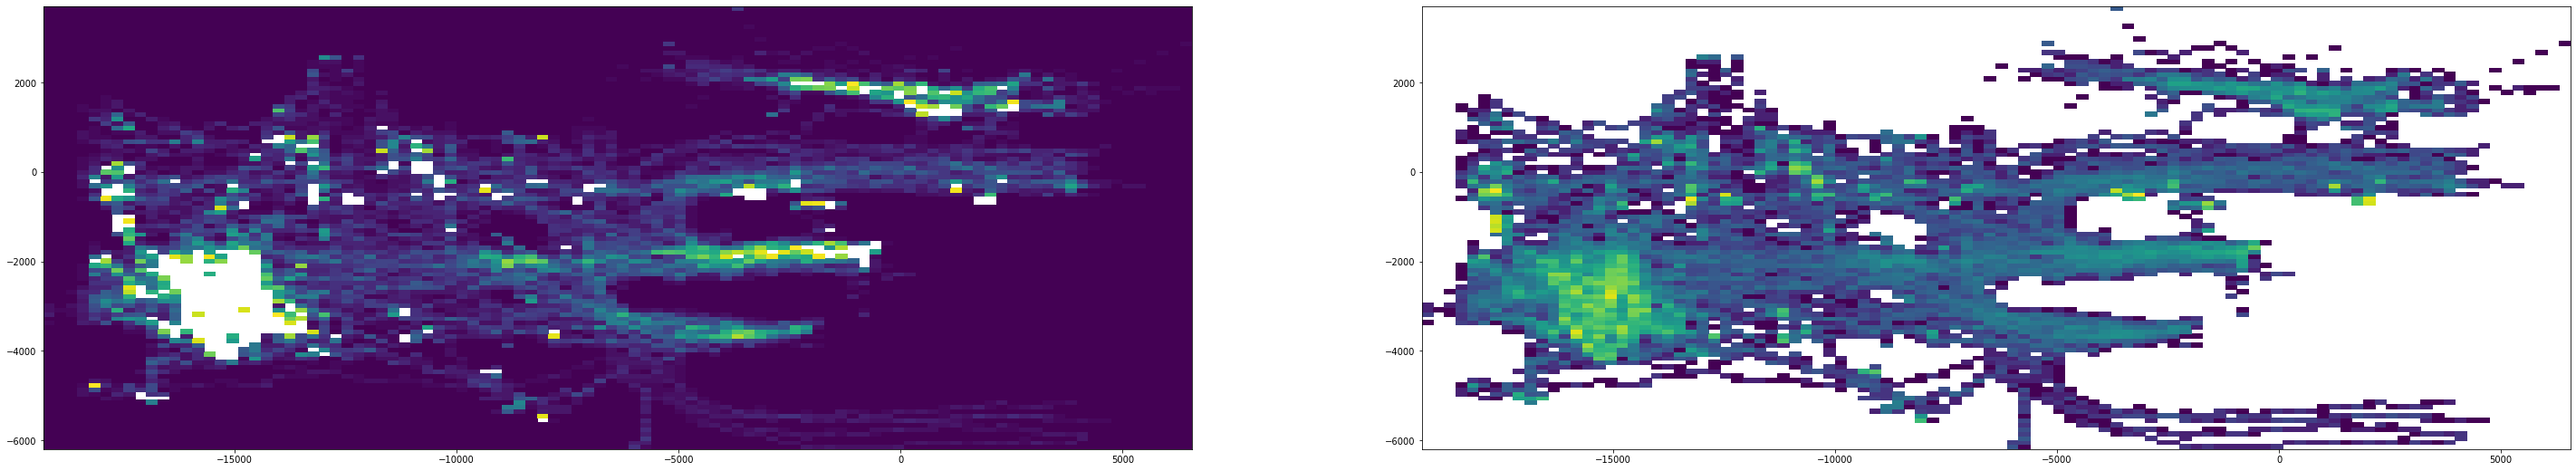

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
x_dim = int((abs(dh.df.x_pos.max()) + abs(dh.df.x_pos.min()))/1000)
y_dim = int((abs(dh.df.y_pos.max()) + abs(dh.df.y_pos.min()))/1000)
fig, ax = plt.subplots(1, 2, figsize = (x_dim*2, y_dim))
ax[0].hist2d(dh.df.x_pos, dh.df.y_pos, bins = (100, 100), cmax = 50);
ax[1].hist2d(dh.df.x_pos, dh.df.y_pos, bins = (100, 100), norm=mpl.colors.LogNorm());

We can also plot the first (red) and the last (blue) position of every pedestrian. Therefor we add two columns to the dataframe. The first column "Rstep_len" contains the length of the trajectory and the second column "R_step" holds the number of each step such that R_step = 0 is the first timestep of that trajectory.

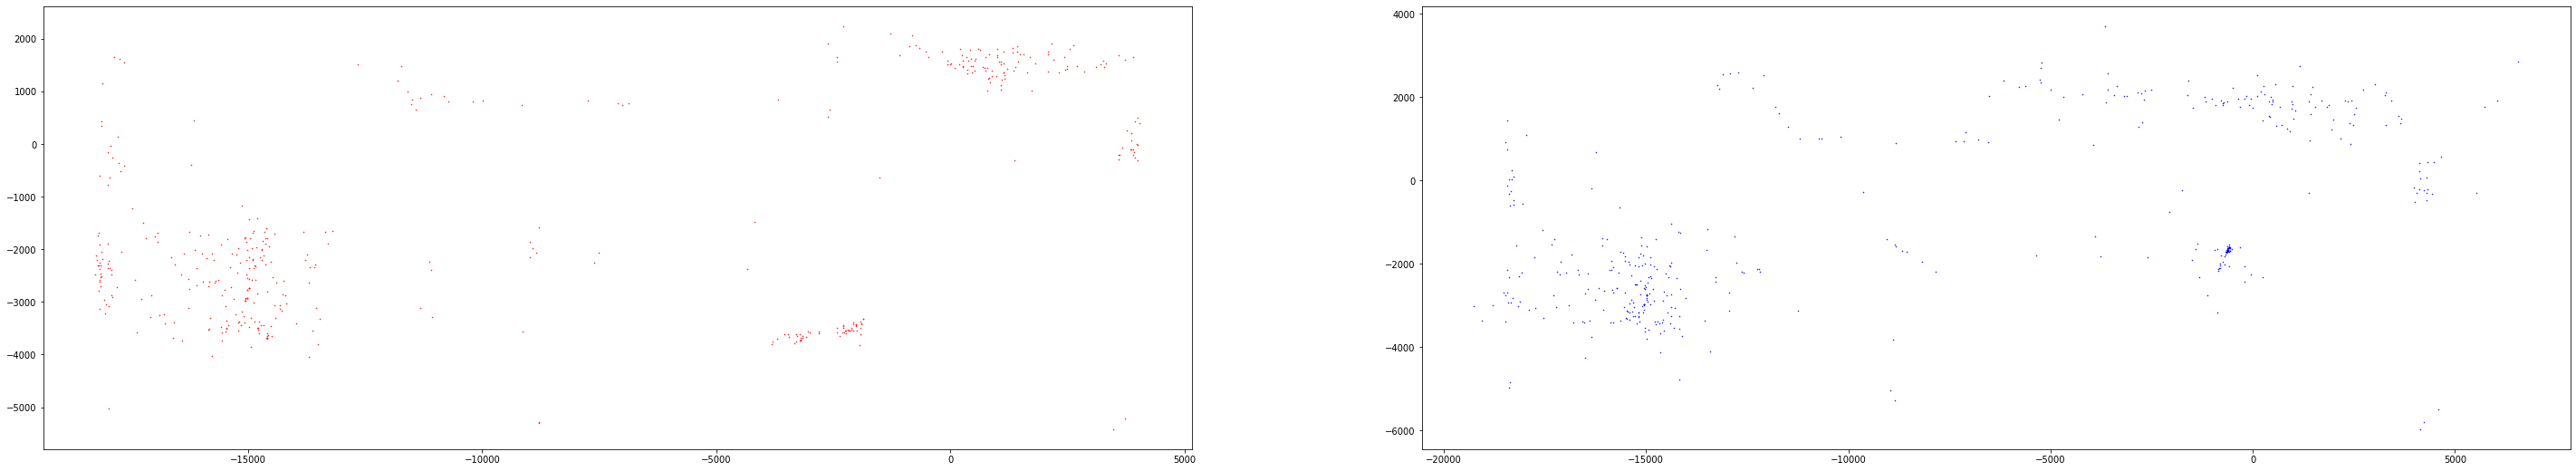

In [ ]:
import numpy as np
dh.df["Rstep_len"] = dh.df.groupby('tracked_object').tracked_object.transform('size')
dh.df["Rstep"] = dh.df.groupby('tracked_object')["Rstep_len"].transform(lambda x: np.arange(x.iloc[0]))

fig, ax = plt.subplots(1, 2, figsize = (x_dim*2, y_dim))
ax[0].plot(dh.df.query('Rstep == 0').x_pos, 
           dh.df.query('Rstep == 0').y_pos, '.r', ms = 1)
ax[1].plot(dh.df.query('Rstep == Rstep_len - 1').x_pos, 
           dh.df.query('Rstep == Rstep_len - 1').y_pos, '.b', ms = 1)

When we want to use the time of the observations it is useflul to convert the UNIX timestamps into datetime objects and set the proper timezone. We also need to order the dataframe on the timestamps.

In [ ]:
import pandas as pd
dh.df['datetime'] = pd.to_datetime(dh.df.date_time_utc, unit='ms')
dh.df['datetime'] = dh.df.datetime.dt.tz_localize('UTC') # First set timezone to UTC
dh.df['datetime'] = dh.df.datetime.dt.tz_convert('Europe/Berlin') # Convert to CET
dh.df = dh.df.sort_values('date_time_utc')

Now we can make a plot of the number of detected people vs the time to get an idea of the moments when people are on the platform. Therefore we need to add a column with the number of objects in each timeframe.


Text(0, 0.5, 'Pedestrians in frame')

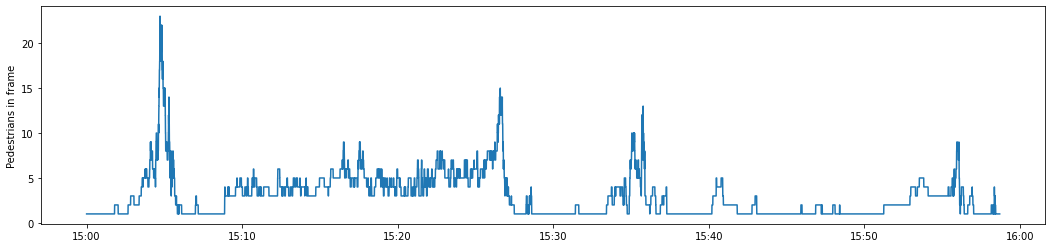

In [ ]:
dh.df['frame_objs'] = dh.df.groupby('date_time_utc').tracked_object.transform('size')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(dh.df.datetime, dh.df.frame_objs)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel('Pedestrians in frame')

The plot above never gets below 1 pedestrian. This is because in the data there exist no observation with 0 pedestrians. All the missing time instances are being automatically filled by the plotting since it connects all the dots with straight lines. When we make the same plot over a shorter time domain this becomes more visible.

Text(0, 0.5, 'Pedestrians in frame')

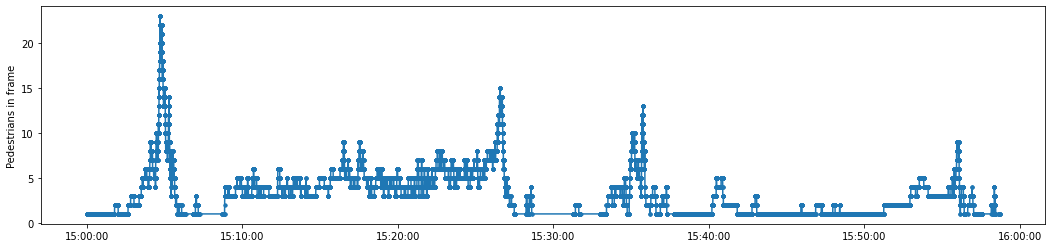

In [ ]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(dh.df.datetime, dh.df.frame_objs, '.-')
# ax.set_xlim(pd.to_datetime('2020-04-28 06:04:00'), 
#             pd.to_datetime('2020-04-28 06:06:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.set_ylabel('Pedestrians in frame')

To fix this we should pad the data with the missing time instances, setting those to 0 pedestrians. Start by creating a dataframe containing all the unix timestamps of that day. Consecutively join this dataframe with the actual trajectories dataset and fill all NaN values with 0.

In [ ]:
all_frames = pd.DataFrame(np.arange(dh.df.date_time_utc.iloc[0], 
                                    dh.df.date_time_utc.iloc[-1], 100), 
                   columns = ['date_time_utc'])
all_frames = all_frames.set_index('date_time_utc')
df_original = dh.df[['date_time_utc','frame_objs']].set_index('date_time_utc')
df_all_frames = all_frames.join(df_original)
df_all_frames = df_all_frames.fillna(0)

Convert the UNIX timestamp again to datetime objects.

In [ ]:
df_all_frames['datetime'] = pd.to_datetime(df_all_frames.index, unit='ms')
df_all_frames['datetime'] = df_all_frames.datetime.dt.tz_localize('UTC') # First set timezone to UTC
df_all_frames['datetime'] = df_all_frames.datetime.dt.tz_convert('Europe/Berlin') # Convert to CET

Plot again to see the difference.

Text(0, 0.5, 'Pedestrians in frame')

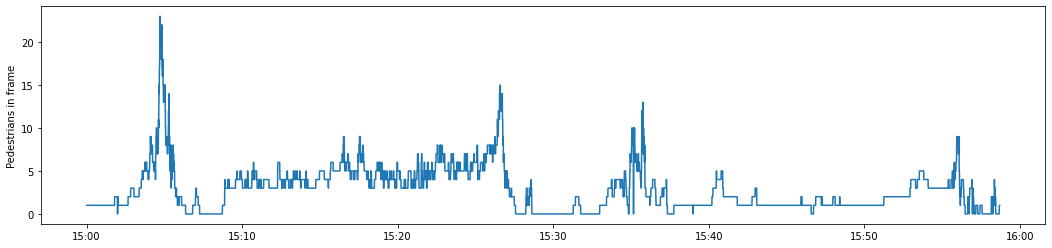

In [ ]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_all_frames.datetime, df_all_frames.frame_objs)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel('Pedestrians in frame')

Text(0, 0.5, 'Pedestrians in frame')

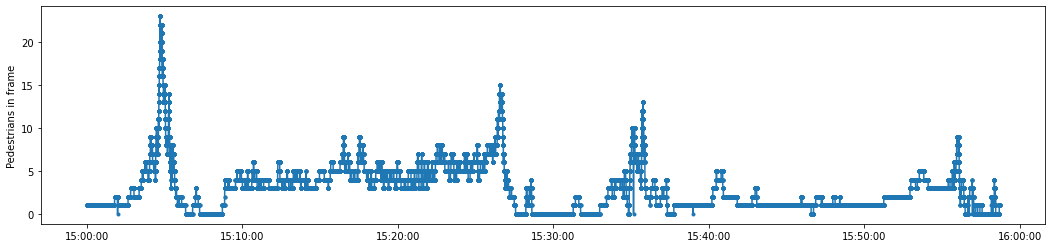

In [ ]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_all_frames.datetime, df_all_frames.frame_objs, '.-')
# ax.set_xlim(pd.to_datetime('2020-04-28 06:04:00'), pd.to_datetime('2020-04-28 06:06:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.set_ylabel('Pedestrians in frame')